In [61]:
import numpy as np
import gc
import matplotlib.pyplot as plt
import math


gc.collect()

0

In [188]:
def t1_t2_relaxations(data_from_DynamicCenter):
    with open(data_from_DynamicCenter,"r") as f:
        read_data=False
        peak_list=False
        peak=0
        results=False
        for line in f:
            if "integrals" in line and len(line.split())==2:
                read_data=True
            elif "results" in line and len(line.split())==2:
                results=True
                peak_dictionary={}


            if "integral errors" in line:
                read_data=False

            if read_data:
                if "Mixing time [s]:" in line:
                    mixing_times=np.array(line.split()[3:])
                    mixing_times = mixing_times.astype('float64')
                elif "Peak name" in line or "SECTION:" in line:
                    pass
                else:
                    if peak==0:
                        intensities=np.array(line.split())
                        intensities = [intensities.astype('float64')]
                        peaks_intensities=intensities
                        line_length=len(line.split())
                    elif line_length==len(line.split()):
                        intensities=np.array(line.split())
                        intensities = [intensities.astype('float64')]
                        peaks_intensities=np.append(peaks_intensities,intensities,axis=0)
                    peak+=1
            elif results:
                if "Peak name" in line or "SECTION:" in line:
                    pass
                else:
                    peak_dictionary[line.split()[0]]={}
                    peak_dictionary[line.split()[0]]["ppm"]=[line.split()[1],line.split()[2]]

    for peak in range(0,peaks_intensities.shape[0]):
        peak_dictionary[str(int(peaks_intensities[peak,0]))]["experiment"]=peaks_intensities[peak,1:]
            
        for_LS=np.array([[0, 0]])
        for i in range(1,peaks_intensities.shape[1]):
            if i<peaks_intensities.shape[1]-1:
                if peaks_intensities[peak,i]<peaks_intensities[peak,i+1]:
                    pass
                elif peaks_intensities[peak,i]==0:
                    break
                else:
                    for_LS=np.append(for_LS,[[mixing_times[i-1],np.log(peaks_intensities[peak,i])]],axis=0)
                       
            else:
                if peaks_intensities[peak,i]==0:
                    break
                else:
                    for_LS=np.append(for_LS,[[mixing_times[i-1],np.log(peaks_intensities[peak,i])]],axis=0)
        for_LS=np.delete(for_LS,0,0)
        curve_fit_coef = np.polyfit(for_LS[:,0], for_LS[:,1], 1, full=True)
            
        
    
        peak_dictionary[str(int(peaks_intensities[peak,0]))]["fit"]=curve_fit_coef
        peak_dictionary[str(int(peaks_intensities[peak,0]))]["points_used"]=len(for_LS)
    #peak_dictionary["mixing_times"]=mixing_times
        
    return peak_dictionary, mixing_times
            

def print_results(*files):
    for file in files:
        relax_data=t1_t2_relaxations(file)
        
        curve_fit_x=np.arange(relax_data[1][0],relax_data[1][-1],0.01)
        for peak in relax_data[0]:
            curve_fit_y=np.exp(curve_fit_x*  relax_data[0][peak]["fit"][0][0])*np.exp(relax_data[0][peak]["fit"][0][1])
                
                
def compare_spectra(reference,*files):
    relaxation_times={}
    for ref_peak in reference:
        relaxation_times[ref_peak]={}
        relaxation_times[ref_peak]["REFERENCE"]={}
        relaxation_times[ref_peak]["REFERENCE"]["ppm"]=reference[ref_peak]["ppm"]
        relaxation_times[ref_peak]["REFERENCE"]["T1"]=  -1/reference[ref_peak]["fit"][0][0]
        #relaxation_times[ref_peak]["REFERENCE"]["error"]=  -1/reference[ref_peak]["fit"][2][0]
        
    for k,file in enumerate(files):
        distances=np.zeros([len(reference),len(file)])
        for i,ref_peak in enumerate(reference):
            #print(float(reference[ref_peak]["ppm"][0]))
            for j,file_peak in enumerate(file):
                distances[i,j]=(math.dist([float(reference[ref_peak]["ppm"][0]), 
                                           float(reference[ref_peak]["ppm"][1])],
                                           [float(file[file_peak]["ppm"][0]),
                                            float(file[file_peak]["ppm"][1])
                                           ])) 
        
        
        if len(reference)>len(file):
            reference_keys=list(reference)
            for i,file_peak in enumerate(file):
                key=np.where(distances[:,i]==min(distances[:,i]))[0][0]
                relaxation_times[reference_keys[key]]["file"+str(k)]={}
                relaxation_times[reference_keys[key]]["file"+str(k)]["ppm"]=file[file_peak]["ppm"]
                relaxation_times[reference_keys[key]]["file"+str(k)]["T1"]=-1/file[file_peak]["fit"][0][0]
        
        #print(distances)
    
    return relaxation_times
    
    

In [189]:
compare_spectra(file1,file2)

{'1': {'REFERENCE': {'ppm': ['128.654', '7.791'], 'T1': 0.9941664203370818}},
 '2': {'REFERENCE': {'ppm': ['126.720', '7.680'], 'T1': 0.9328434089501176}},
 '3': {'REFERENCE': {'ppm': ['125.559', '8.230'], 'T1': 0.6548059568326506},
  'file0': {'ppm': ['125.559', '8.230'], 'T1': 0.6548059568326506}},
 '4': {'REFERENCE': {'ppm': ['125.431', '8.318'], 'T1': 0.7765184003916634},
  'file0': {'ppm': ['125.431', '8.318'], 'T1': 0.7765184003916634}}}

In [153]:
list(file1)

['1', '2', '3', '4']

In [147]:
distances=np.array([[0, 1 ,2, 3],[1, 2 ,3 ,4],[5, 6 ,7, 8]])
distances==3
result = np.where(distances == 2)
print(result)

(array([0, 1]), array([2, 1]))


In [110]:
file1={'1': {'ppm': ['128.654', '7.791'],
  'experiment': ([2.66199605e+08, 2.76754233e+08, 2.67231965e+08, 2.42918607e+08,
         2.18954219e+08, 1.78950290e+08, 1.44474162e+08, 1.17751359e+08,
         6.48712580e+07, 4.38294230e+07]),
  'fit': (([-1.00586781, 19.50000135]),
   ([0.0005226]),
   2,
   ([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9},
 '2': {'ppm': ['126.720', '7.680'],
  'experiment': ([6936458., 6773242., 6408975., 5836295., 5240226., 4144097.,
         3242151., 2801335., 1351417.,  967518.]),
  'fit': (([-1.07199128, 15.77933735]),
   ([0.00742652]),
   2,
   ([1.3076509 , 0.53856209]),
   2.220446049250313e-15),
  'points_used': 10},
 '3': {'ppm': ['125.559', '8.230'],
  'experiment': ([1.90830240e+08, 2.06826813e+08, 1.95401945e+08, 1.65435954e+08,
         1.40038412e+08, 1.00696809e+08, 7.25271090e+07, 5.30875780e+07,
         2.24173190e+07, 1.25247520e+07]),
  'fit': (([-1.52716998, 19.21052111]),
   ([0.0073473]),
   2,
   ([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9},
 '4': {'ppm': ['125.431', '8.318'],
  'experiment': ([1.21772446e+08, 1.35995698e+08, 1.28611995e+08, 1.10654278e+08,
         9.72411730e+07, 7.52404000e+07, 5.71898020e+07, 4.36969990e+07,
         2.15718770e+07, 1.23437260e+07]),
  'fit': (([-1.28779949, 18.78238576]),
   ([0.00313412]),
   2,
   ([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9}}

file2={
 '3': {'ppm': ['125.559', '8.230'],
  'experiment': ([1.90830240e+08, 2.06826813e+08, 1.95401945e+08, 1.65435954e+08,
         1.40038412e+08, 1.00696809e+08, 7.25271090e+07, 5.30875780e+07,
         2.24173190e+07, 1.25247520e+07]),
  'fit': (([-1.52716998, 19.21052111]),
   ([0.0073473]),
   2,
   ([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9},
 '4': {'ppm': ['125.431', '8.318'],
  'experiment': ([1.21772446e+08, 1.35995698e+08, 1.28611995e+08, 1.10654278e+08,
         9.72411730e+07, 7.52404000e+07, 5.71898020e+07, 4.36969990e+07,
         2.15718770e+07, 1.23437260e+07]),
  'fit': (([-1.28779949, 18.78238576]),
   ([0.00313412]),
   2,
   ([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9}}

In [106]:
t1_t2_relaxations("COR15A_20mM_NaP_T1_181incr_not_all_first_ponts_removed.txt")[0]

{'1': {'ppm': ['128.654', '7.791'],
  'experiment': array([2.66199605e+08, 2.76754233e+08, 2.67231965e+08, 2.42918607e+08,
         2.18954219e+08, 1.78950290e+08, 1.44474162e+08, 1.17751359e+08,
         6.48712580e+07, 4.38294230e+07]),
  'fit': (array([-1.00586781, 19.50000135]),
   array([0.0005226]),
   2,
   array([1.32134322, 0.50403581]),
   1.9984014443252818e-15),
  'points_used': 9},
 '2': {'ppm': ['126.720', '7.680'],
  'experiment': array([6936458., 6773242., 6408975., 5836295., 5240226., 4144097.,
         3242151., 2801335., 1351417.,  967518.]),
  'fit': (array([-1.07199128, 15.77933735]),
   array([0.00742652]),
   2,
   array([1.3076509 , 0.53856209]),
   2.220446049250313e-15),
  'points_used': 10},
 '3': {'ppm': ['125.559', '8.230'],
  'experiment': array([1.90830240e+08, 2.06826813e+08, 1.95401945e+08, 1.65435954e+08,
         1.40038412e+08, 1.00696809e+08, 7.25271090e+07, 5.30875780e+07,
         2.24173190e+07, 1.25247520e+07]),
  'fit': (array([-1.52716998, 19.

In [70]:
compare_spectra(t1_t2_relaxations("COR15A_20mM_NaP_T1_181incr_not_all_first_ponts_removed.txt")[0],t1_t2_relaxations("COR15A_20mM_NaP_T1_181incr_not_all_first_ponts_removed.txt")[0])

array([[ 0.        ,  1.93718275,  3.12597921, ..., 19.63504329,
        19.73517552, 20.44206692],
       [ 1.93718275,  0.        ,  1.28468712, ..., 17.70473247,
        17.80595097, 18.51202001],
       [ 3.12597921,  1.28468712,  0.        , ..., 16.53500109,
        16.63250026, 17.34110037],
       ...,
       [19.63504329, 17.70473247, 16.53500109, ...,  0.        ,
         0.1566461 ,  0.80774068],
       [19.73517552, 17.80595097, 16.63250026, ...,  0.1566461 ,
         0.        ,  0.71244719],
       [20.44206692, 18.51202001, 17.34110037, ...,  0.80774068,
         0.71244719,  0.        ]])

In [39]:
def pokus(*pokusne):
    for i in pokusne:
        print(i[0])
        
        
def pokus2(n):
    ahoj=34*n
    blb="dfdf"
    return ahoj, blb

In [40]:
pokus(pokus2(2),pokus2(1))

68
34


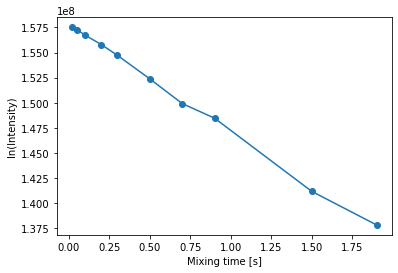

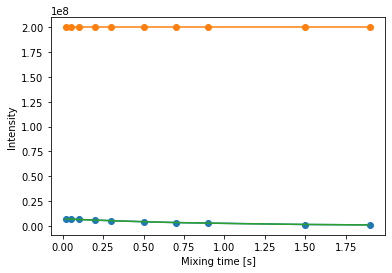

0.9328434072100882


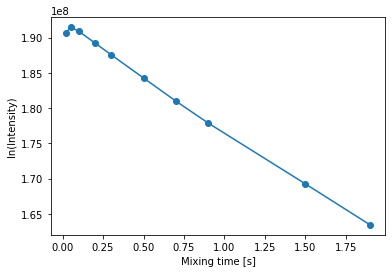

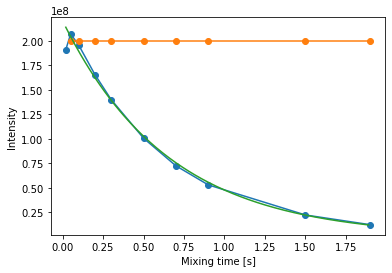

0.654805955799244


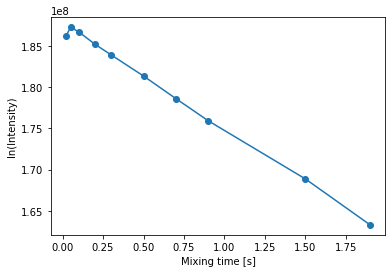

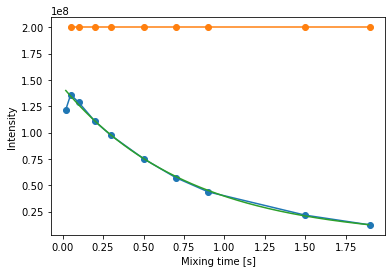

0.7765184032759271


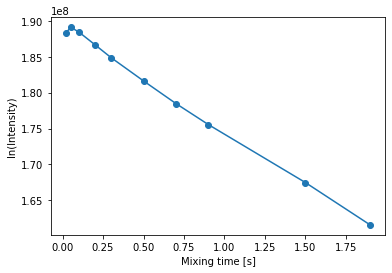

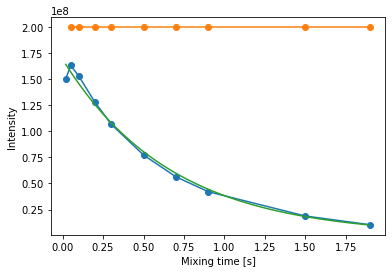

0.6729845175180343


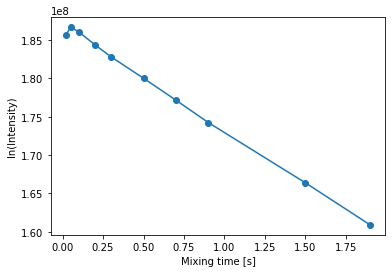

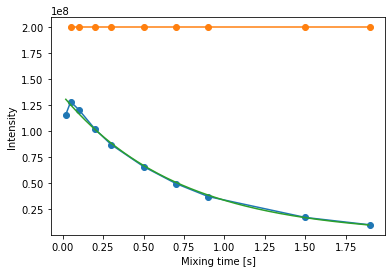

0.717961909883509


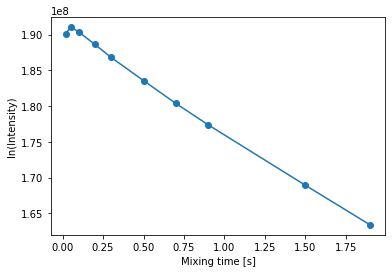

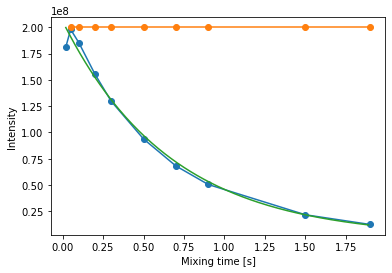

0.6656962857563117


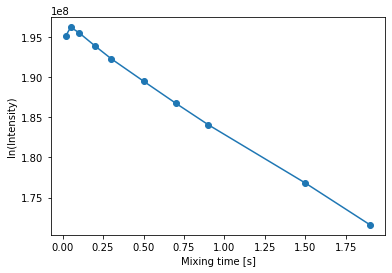

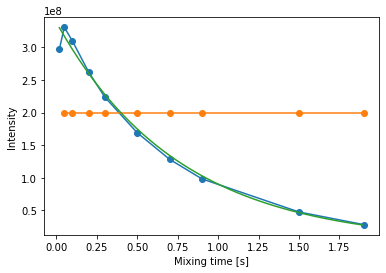

0.7568937725138244


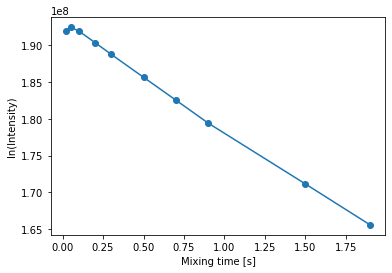

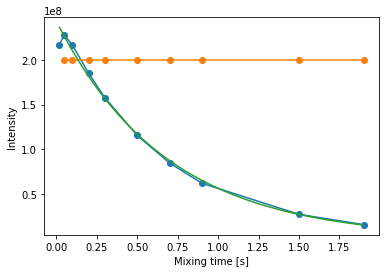

0.6822301725614565


/tmp/ipykernel_6264/1917240278.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(mixing_times, 10000000*np.log(peaks_intensities[peak,1:]),'o-')


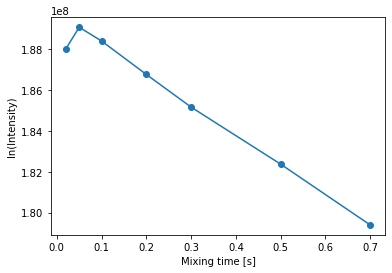

TypeError: _delete_dispatcher() missing 1 required positional argument: 'obj'

In [75]:
T1_values=[]
for peak in range(1,peaks_intensities.shape[0]):
    #plt.ylim([1.5*10**8, 2*10**8])
    #plt.plot(mixing_times, peaks_intensities[i,1:])
    plt.plot(mixing_times, 10000000*np.log(peaks_intensities[peak,1:]),'o-')
    plt.xlabel('Mixing time [s]')
    plt.ylabel('ln(Intensity)')
    plt.show()
    
    for_LS=np.array([[0, 0]])
    for i in range(1,peaks_intensities.shape[1]):
        if i<peaks_intensities.shape[1]-1:
            if peaks_intensities[peak,i]<peaks_intensities[peak,i+1]:
                pass
            elif peaks_intensities[peak,i]==0:
                np.delete(peaks_intensities[peak,i])
                #break
            else:
                for_LS=np.append(for_LS,[[mixing_times[i-1],np.log(peaks_intensities[peak,i])]],axis=0)
                #for_LS.append([mixing_times[i-1],peaks_intensities[peak,i]])
        else:
            if peaks_intensities[peak,i]==0:
                break
            else:
                for_LS=np.append(for_LS,[[mixing_times[i-1],np.log(peaks_intensities[peak,i])]],axis=0)
    for_LS=np.delete(for_LS,0,0)
    curve_fit_coef = np.polyfit(for_LS[:,0], for_LS[:,1], 1, full=True)
    curve_fit_x=np.arange(mixing_times[0],mixing_times[-1],0.01)
    curve_fit_y=np.exp(curve_fit_x*curve_fit_coef[0][0])*np.exp(curve_fit_coef[0][1])
    
    
    plt.plot(mixing_times, peaks_intensities[peak,1:],'o-')
    plt.plot(for_LS[:,0], for_LS[:,1]+2*10**8,'o-')
    plt.plot(curve_fit_x, curve_fit_y,'-')
    plt.xlabel('Mixing time [s]')
    plt.ylabel('Intensity')
    plt.show()
    
    print(-1/curve_fit_coef[0][0])
    T1_values.append(-1/curve_fit_coef[0][0])
    #print(np.log(peaks_intensities[peak,1:]))
    #print(np.log(peaks_intensities[i,1:]))
    #print(peaks_intensities[i,1:])

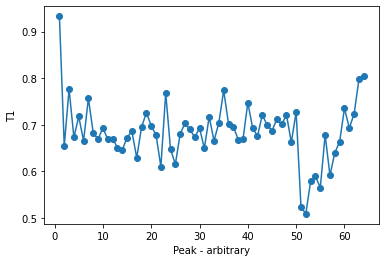

In [159]:
x_data=np.arange(1,len(T1_values)+1,1)
plt.plot(x_data, T1_values,'o-')
plt.xlabel('Peak - arbitrary')
plt.ylabel('T1')
plt.show()

In [43]:
def count(a, b):
    occured={}
    bigger=0
    for i in range(1,len(a)+1):
        occured[i]=False
    
    for i in range(0,len(a)):
        if occured[b[i]]:
            bigger+=1
        occured[a[i]]=True
    
    return bigger
    # TODO

if __name__ == "__main__":
    print(count([1,2,3], [1,2,3])) # 0
    print(count([2,3,4,1], [1,2,3,4])) # 3
    print(count([4,7,3,1,6,2,5], [5,6,1,2,4,3,7])) # 3
    print(count([5,4,9,1,8,3,2,6,7], [6,2,8,4,9,1,5,7,3])) # 5

0
3
3
5
